## Experimental Variogram

In [25]:
import numpy as np
import pandas as pd
import skgstat as skg
from sklearn.preprocessing import QuantileTransformer
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gstatsim as gs
import matplotlib.pylab as plt
from skgstat import models

In [26]:
df_bed = pd.read_csv(r'D:\gunung1.csv')
# remove erroneously high values due to bad bed picks
df_bed = df_bed[df_bed['Bed'] <= 2300]
df_bed.head()

,X,Y,Bed
0,116.328393,-8.47975,934.59357
1,116.399533,-8.36506,2043.91260
4,116.288237,-8.44935,893.89600
5,116.407118,-8.31497,744.92004
6,116.410837,-8.39989,2005.31274


In [27]:
print(f'The data length is {len(df_bed)}')

The data length is 791


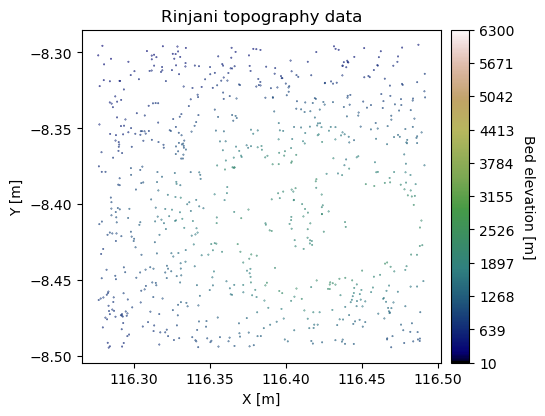

In [29]:
# plot data
fig = plt.figure(figsize = (5,5))
ax = plt.gca()
im = ax.scatter(df_bed['X'], df_bed['Y'], c=df_bed['Bed'], vmin=10, vmax=6300, 
                     marker='.', s=0.5, cmap='gist_earth')
plt.title('Rinjani topography data')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.locator_params(nbins=5)
plt.axis('scaled')

# make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(10, 6300, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)
plt.show()

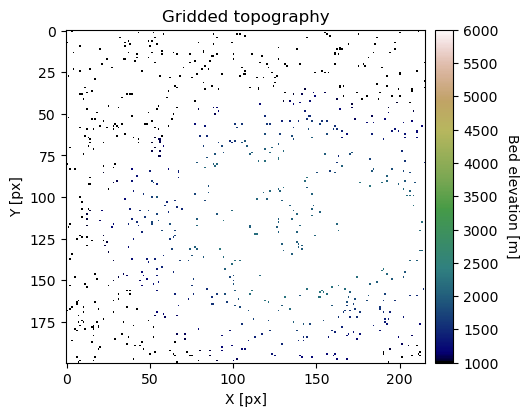

In [42]:
# grid data to 0,001 m resolution
res = 0.001
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'X', 'Y', 'Bed', res)

# plot gridded bed
fig = plt.figure(figsize = (5,5))
ax = plt.gca()
im = ax.imshow(grid_matrix, cmap='gist_earth', vmin=1000, vmax=6000, 
                interpolation='none', origin='upper')
plt.title('Gridded topography')
plt.xlabel('X [px]'); plt.ylabel('Y [px]')

# make color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(1000, 6000, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)
plt.show()

In [43]:
# remove nans
df_grid = df_grid[df_grid['Z'].isnull() == False]
df_grid.head()

,X,Y,Sum,Count,Z
7,116.283591,-8.49437,592.64636,1.0,592.64636
66,116.342591,-8.49437,871.17603,1.0,871.17603
193,116.469591,-8.49437,924.62543,1.0,924.62543
224,116.284591,-8.49337,600.33398,1.0,600.33398
232,116.292591,-8.49337,599.33459,1.0,599.33459


In [44]:
# normal score transformation
data = df_grid['Z'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=50, output_distribution='normal').fit(data)
df_grid['Nbed'] = nst_trans.transform(data) 

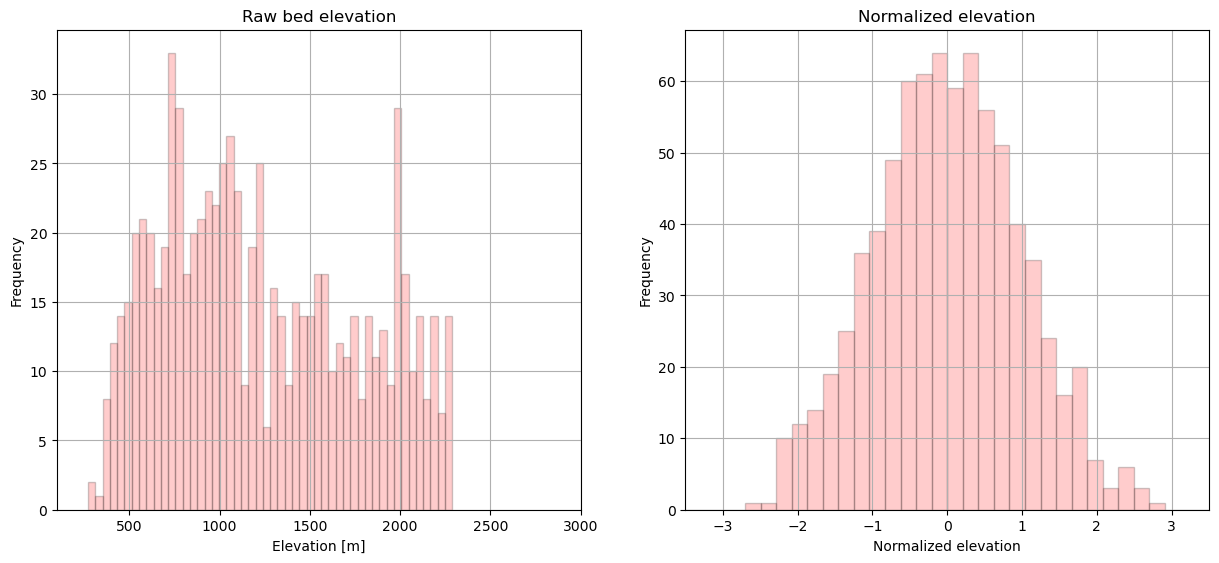

In [45]:
# plot original bed histogram
plt.subplot(121)
plt.hist(df_grid['Z'], facecolor='red', bins=50, alpha=0.2, edgecolor='black')
plt.xlim([100,3000]); 
plt.xlabel('Elevation [m]'); plt.ylabel('Frequency'); plt.title('Raw bed elevation')
plt.grid(True)

# plot normal score bed histogram (with weights)
plt.subplot(122)
plt.hist(df_grid['Nbed'], facecolor='red', bins=50, alpha=0.2, edgecolor='black')
plt.xlim([-3.5,3.5]); 
plt.xlabel('Normalized elevation'); plt.ylabel('Frequency'); plt.title('Normalized elevation')
plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

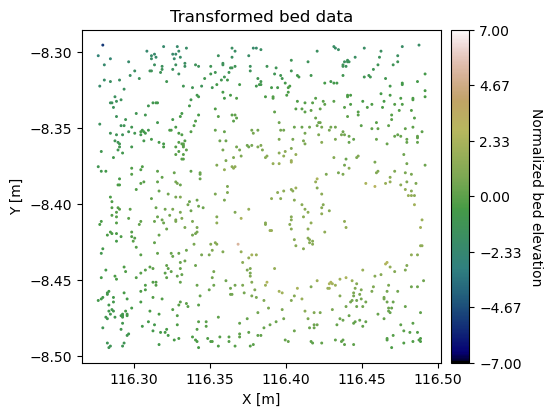

In [46]:
# plot transformed data
fig = plt.figure(figsize = (5,5))
ax = plt.gca()
im = ax.scatter(df_grid['X'], df_grid['Y'], c=df_grid['Nbed'], vmin=-7, vmax=7, 
                     marker='.', s=5, cmap='gist_earth')
plt.title('Transformed bed data')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.locator_params(nbins=5)
plt.axis('scaled')

# make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-7, 7, 7), cax=cax)
cbar.set_label("Normalized bed elevation", rotation=270, labelpad=15)
plt.show()

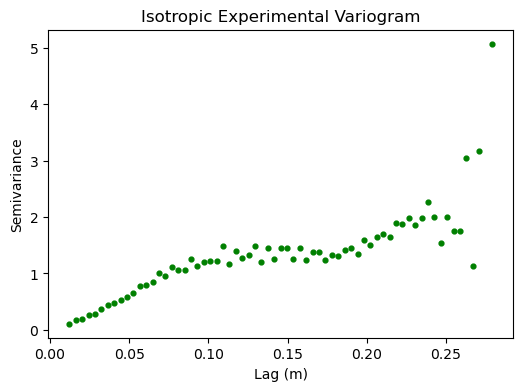

In [13]:
# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nbed']

maxlag = 50000      # maximum range distance
n_lags = 70         # num of bins

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

In [14]:
# directional variogram

V0 = skg.DirectionalVariogram(coords, values, bin_func = "even", n_lags = n_lags, 
                                  maxlag = maxlag, normalize=False, azimuth=0, tolerance=15)

V45 = skg.DirectionalVariogram(coords, values, bin_func = "even", n_lags = n_lags, 
                                  maxlag = maxlag, normalize=False, azimuth=45, tolerance=15)

V90 = skg.DirectionalVariogram(coords, values, bin_func = "even", n_lags = n_lags, 
                                   maxlag = maxlag, normalize=False, azimuth=90, tolerance=15)

V135 = skg.DirectionalVariogram(coords, values, bin_func = "even", n_lags = n_lags, 
                                  maxlag = maxlag, normalize=False, azimuth=135, tolerance=15)

x0 = V0.bins
y0 = V0.experimental

x45 = V45.bins
y45 = V45.experimental

x90 = V90.bins
y90 = V90.experimental

x135 = V135.bins
y135 = V135.experimental

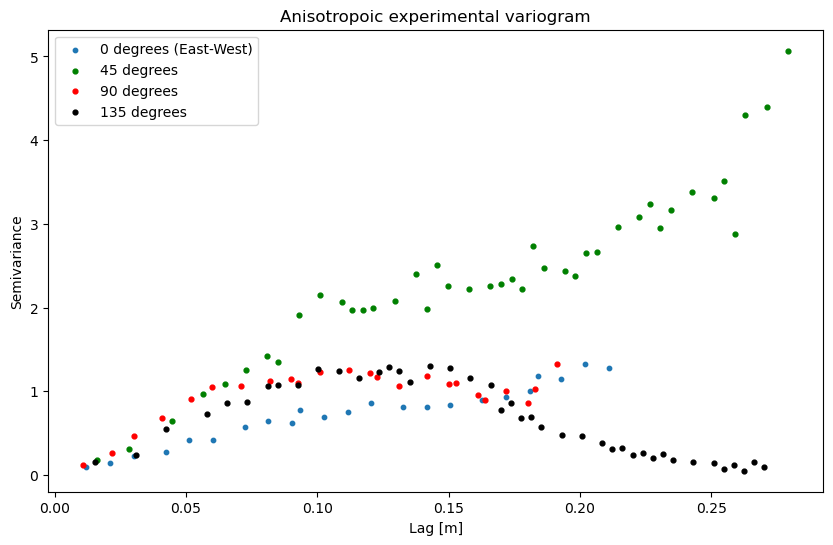

In [15]:
# plot multidirectional variogram
plt.figure(figsize=(10,6))
plt.scatter(x0, y0, s=10, label='0 degrees (East-West)')
plt.scatter(x45, y45,s=12, c='g', label='45 degrees')
plt.scatter(x90, y90, s=12, c='r', label='90 degrees')
plt.scatter(x135, y135, s=12, c='k', label='135 degrees')
plt.title('Anisotropoic experimental variogram')
plt.xlabel('Lag [m]'); plt.ylabel('Semivariance')
plt.legend(loc='upper left')
plt.show()

## Variogram Model


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import QuantileTransformer 
import skgstat as skg
from skgstat import models
import gstatsim as gs

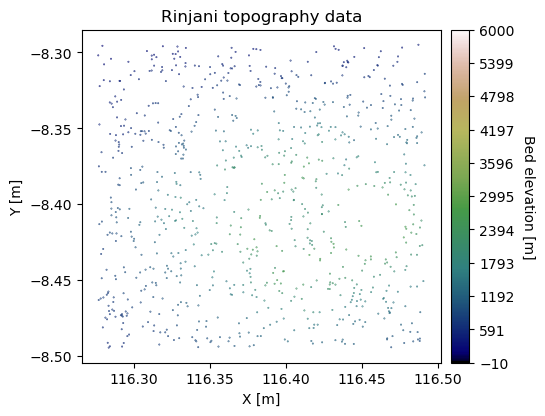

In [53]:
df_bed = pd.read_csv(r'D:\gunung1.csv')

# remove erroneously high values due to bad bed picks
df_bed = df_bed[df_bed["Bed"] <= 2700]  

# plot data
fig = plt.figure(figsize = (5,5))
ax = plt.gca()
im = ax.scatter(df_bed['X'], df_bed['Y'], c=df_bed['Bed'], vmin=-10, vmax=6000, 
                     marker='.', s=0.5, cmap='gist_earth')
plt.title('Rinjani topography data')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.locator_params(nbins=5)
plt.axis('scaled')

# make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-10, 6000, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)
plt.show()

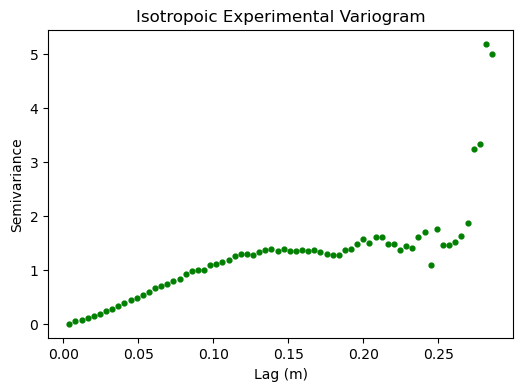

In [55]:
# grid data to 1000 m resolution and remove coordinates with NaNs
res = 0.001
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'X', 'Y', 'Bed', res)
df_grid = df_grid[df_grid["Z"].isnull() == False]
df_grid = df_grid.rename(columns = {"Z": "Bed"})

# normal score transformation
data = df_grid['Bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data)
df_grid['Nbed'] = nst_trans.transform(data) 

# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nbed']

maxlag = 50000          # maximum range distance
n_lags = 70             # num of bins

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, 
                   maxlag=maxlag, normalize=False)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.title('Isotropoic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')  
plt.show()

In [56]:
# use exponential variogram model
V1.model = 'exponential' 
V1.parameters

[0.2858426140385211, 1.9194480896819777, 0]

In [57]:
# use Gaussian model
V2 = V1
V2.model = 'gaussian' 
V2.parameters

[0.2858426140385211, 2.1398400041634917, 0]

In [58]:
# use spherical model
V3 = V1
V3.model = 'spherical' 
V3.parameters

[0.2858426140385211, 2.028911200271272, 0]

In [59]:
# evaluate models
xi =np.linspace(0, xdata[-1], 100) 

y_exp = [models.exponential(h, V1.parameters[0], V1.parameters[1], V1.parameters[2]) for h in xi]
y_gauss = [models.gaussian(h, V2.parameters[0], V2.parameters[1], V2.parameters[2]) for h in xi]
y_sph = [models.spherical(h, V3.parameters[0], V3.parameters[1], V3.parameters[2]) for h in xi]

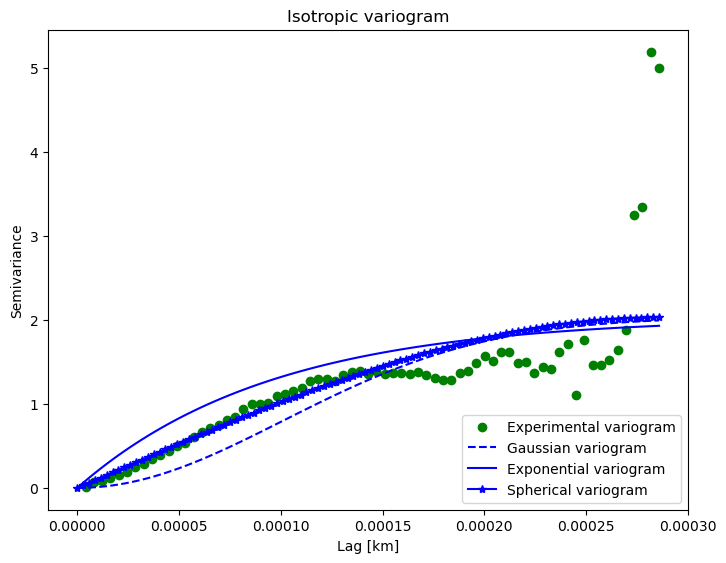

In [60]:
# plot variogram model
fig = plt.figure()
plt.plot(xdata/1000,ydata,'og', label = "Experimental variogram")
plt.plot(xi/1000, y_gauss,'b--', label='Gaussian variogram')
plt.plot(xi/1000, y_exp,'b-', label='Exponential variogram')
plt.plot(xi/1000, y_sph,'b*-', label='Spherical variogram')
plt.title('Isotropic variogram')
plt.xlabel('Lag [km]'); plt.ylabel('Semivariance')  
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.0) # adjust the plot size
plt.legend(loc='lower right')

### Simple kriging and ordinary kriging

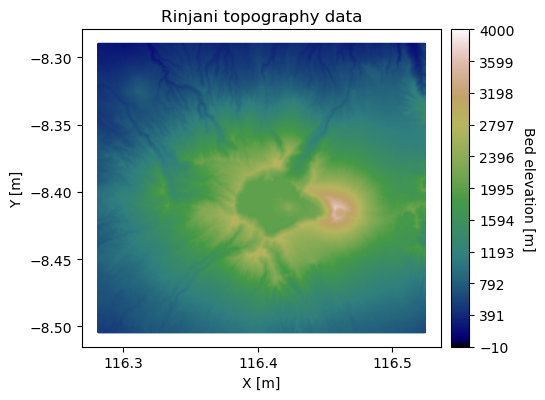